In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
data_final=pd.read_csv("/content/finance_data.csv")

In [66]:
df = data_final[data_final['US_Bank'] == 'BAC'].copy()

# Chuyển Date sang datetime và sort
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

# Reset index integer để tránh lỗi ARIMA
df.reset_index(drop=True, inplace=True)
df['Close'].ffill(inplace=True)  # điền NaN

print("Dữ liệu đầu:", df.head())


Dữ liệu đầu:    Unnamed: 0       Date US_Bank       Open       High        Low      Close  \
0           0 2015-10-14     BAC  15.770000  15.920000  15.550000  15.640000   
1           1 2015-10-15     BAC  15.810000  16.280001  15.720000  16.190001   
2           2 2015-10-16     BAC  16.290001  16.290001  16.030001  16.120001   
3           3 2015-10-19     BAC  16.000000  16.209999  15.980000  16.139999   
4           4 2015-10-20     BAC  16.160000  16.290001  16.100000  16.200001   

   Adjusted Close     Volume  
0       12.591779  122272400  
1       13.034586  127028800  
2       12.978229   66989500  
3       12.994333   62953500  
4       13.042639   50797800  


/tmp/ipython-input-2265229744.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Close'].ffill(inplace=True)  # điền NaN


#Applying time series modelling to build algorithms trading

##Kiểm tra stationary: phương pháp phổ biến Augmented Dickey-Fuller (ADF) test.

Nếu p<=0.05->stationary->có thể dùng AR,MA trực tiếp

Nếu không->cần differencing hoặc log turn để đạt stationarity

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# -------------------------
# Kiểm tra Stationarity
# -------------------------
def check_stationarity(series, signif=0.05):
    result = adfuller(series)
    print(result)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critical Values:', key, value)
    if result[1] < signif:
        print("Chuỗi là stationary")
        return True
    else:
        print("Chuỗi là non-stationary")
        return False

# Kiểm tra giá đóng cửa
print("Kiểm tra stationarity của Close Price:")
check_stationarity(df['Close'])


Kiểm tra stationarity của Close Price:
(np.float64(-1.5357582723734087), np.float64(0.5157539530054754), 8, 2504, {'1%': np.float64(-3.4329642237790847), '5%': np.float64(-2.862694950990622), '10%': np.float64(-2.5673848250020415)}, np.float64(4351.767252399381))
ADF Statistic: -1.5357582723734087
p-value: 0.5157539530054754
Critical Values: 1% -3.4329642237790847
Critical Values: 5% -2.862694950990622
Critical Values: 10% -2.5673848250020415
Chuỗi là non-stationary


False

p-value=0.5157>0.05->Chuỗi là non-stationary, để stationary ADF phải nhỏ hơn critical value
=> non-stationary =>transform sang log returns

In [68]:
df['LogRet'] = np.log(df['Close'] / df['Close'].shift(1))
df = df.dropna() #item đầu

In [69]:
check_stationarity(df['LogRet'])

(np.float64(-15.944055322850323), np.float64(7.484200327892872e-29), 8, 2503, {'1%': np.float64(-3.4329652692893364), '5%': np.float64(-2.8626954126892405), '10%': np.float64(-2.567385070816339)}, np.float64(-12494.324380495702))
ADF Statistic: -15.944055322850323
p-value: 7.484200327892872e-29
Critical Values: 1% -3.4329652692893364
Critical Values: 5% -2.8626954126892405
Critical Values: 10% -2.567385070816339
Chuỗi là stationary


True

Dùng được cho ARIMA

In [70]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Tính Log Return
df['LogRet'] = np.log(df['Close'] / df['Close'].shift(1))

# XÓA đúng NaN trong toàn DataFrame:
df = df.dropna(subset=['LogRet']).reset_index(drop=True)



Chia data thành 80% train, 20% test

In [71]:
# Tính log return
df['LogRet'] = np.log(df['Close'] / df['Close'].shift(1))
df.dropna(inplace=True)

# Chia dữ liệu train/test (80% train, 20% test)
split_point = int(len(df) * 0.8)
train_data = df['LogRet'].iloc[:split_point]
test_data  = df['LogRet'].iloc[split_point:]

train_dates = df['Date'].iloc[:split_point]
test_dates  = df['Date'].iloc[split_point:]

print("Train size:", len(train_data))
print("Test size:", len(test_data))



Train size: 2008
Test size: 502


In [72]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(1,0,1)) #Dùng 1 AR và 1 MA, vì data đã stationary rồi
model_fit = model.fit()
print(model_fit.summary())


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 LogRet   No. Observations:                 2008
Model:                 ARIMA(1, 0, 1)   Log Likelihood                4961.076
Date:                Fri, 05 Dec 2025   AIC                          -9914.153
Time:                        13:45:19   BIC                          -9891.733
Sample:                             0   HQIC                         -9905.923
                               - 2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      0.570      0.569      -0.001       0.001
ar.L1         -0.5629      0.095     -5.954      0.000      -0.748      -0.378
ma.L1          0.5070      0.097      5.206      0.0

Dự đáon giá trên train,

In [73]:
# Dự đoán Log Return trên Test Data (Static Forecast)
test_pred_logret = model_fit.forecast(steps=len(test_data))


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


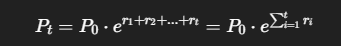

In [74]:
#  Chuyển Log Return dự đoán về Price
last_train_price = df['Close'].iloc[split_point-1]
pred_price = last_train_price * np.exp(test_pred_logret.cumsum())

In [75]:
#  Đánh giá RMSE (trên Log Returns)
from sklearn.metrics import mean_squared_error
rmse_logret = np.sqrt(mean_squared_error(test_data, test_pred_logret))
print(f'\nTest RMSE (LogRet): {rmse_logret:.4f}')



Test RMSE (LogRet): 0.0163


In [76]:
#Đánh giá RMSE (trên Price)
actual_price = df['Close'].iloc[split_point:]
rmse_price = np.sqrt(mean_squared_error(actual_price, pred_price))
print(f'Test RMSE (Price): {rmse_price:.2f}')

Test RMSE (Price): 12.85


Dự báo khá chính xác trên tập test (giá trị sai số trung bình khoảng 1.6%).

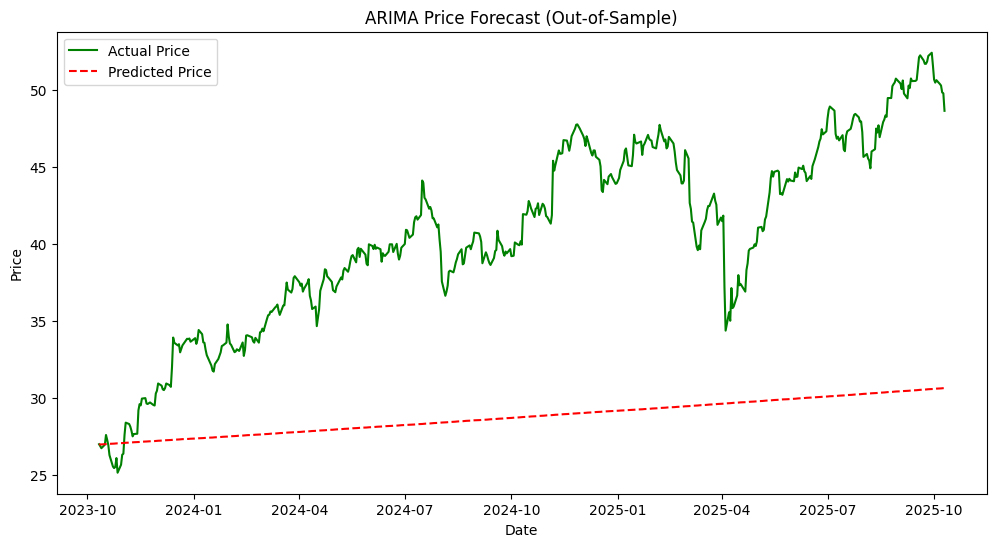

In [77]:
#  Vẽ Actual vs Predicted Price (trên tập Test)
plt.figure(figsize=(12,6))
plt.plot(test_dates, actual_price, label='Actual Price', color='green')
plt.plot(test_dates, pred_price, label='Predicted Price', color='red', linestyle='--')
plt.title('ARIMA Price Forecast (Out-of-Sample)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


Do LogRet là chuỗi stationary , dao động quanh 0 , ARIMA(1,0,1) đơn giản thường chỉ có thể dự báo tốt trong ngắn hạn và thường trở về giá trị trung bình của chuỗi Stationary trong dài hạn (thếu biến ngoại sinh :không chỉ dựa vào giá trị trong lịch sử)=> Giải pháp sử dụng Rolling Forecast. Thay vì fit một lần, mô hình được fit lại hoặc cập nhật sau mỗi khoảng thời gian (hoặc mỗi ngày) bằng cách bao gồm dữ liệu thực tế mới nhất.

In [78]:
# Tín hiệu dựa trên so sánh giá dự đoán ngày t và ngày t-1
pred_price_list = pred_price.tolist()

# signal: 1=BUY (dự kiến tăng), -1=SELL (dự kiến giảm)
signals = [
    1 if pred_price_list[i] > pred_price_list[i-1] else -1
    for i in range(1, len(pred_price_list))
]
signals.insert(0, 0) # Tín hiệu đầu tiên (giả sử 0)



Sharpe Ratio (Chiến lược ARIMA): 1.2523


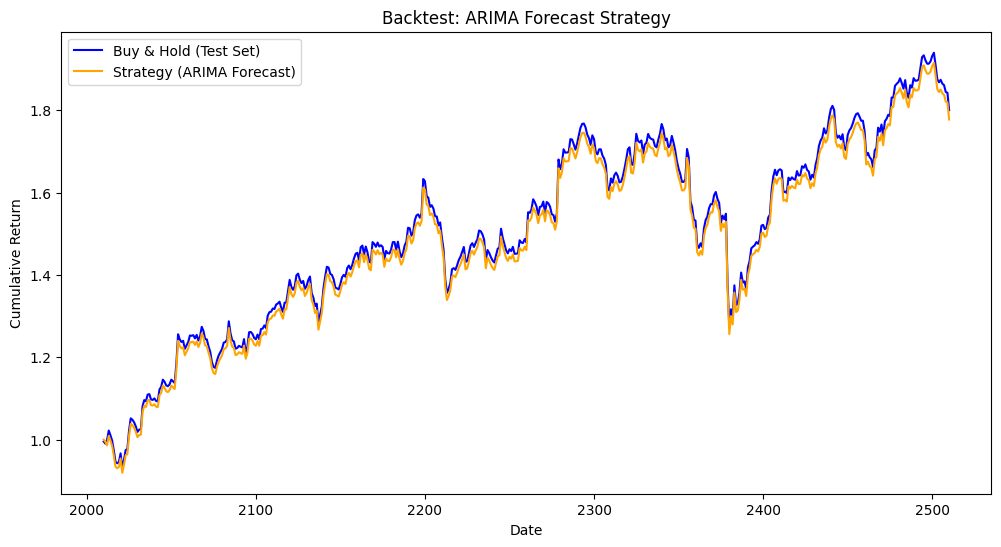

In [79]:
# Thực hiện Backtest đơn giản trên tập Test
test_returns = df['Close'].iloc[split_point:].pct_change().dropna()
signals_for_return = pd.Series(signals[1:], index=test_returns.index).shift(1).fillna(0) # shift 1 để tránh lookahead, sử dụng signals[1:] để khớp độ dài
signals_for_return = signals_for_return.loc[test_returns.index] # đảm bảo index khớp

# Lợi nhuận chiến lược
strategy_return = signals_for_return * test_returns
cumulative_strategy = (1 + strategy_return).cumprod()
cumulative_market = (1 + test_returns).cumprod()

# Đánh giá hiệu suất
sharpe_ratio = (strategy_return.mean() / strategy_return.std()) * np.sqrt(252)

print(f'\nSharpe Ratio (Chiến lược ARIMA): {sharpe_ratio:.4f}')

plt.figure(figsize=(12,6))
plt.plot(cumulative_market, label='Buy & Hold (Test Set)', color='blue')
plt.plot(cumulative_strategy, label='Strategy (ARIMA Forecast)', color='orange')
plt.title('Backtest: ARIMA Forecast Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

In [80]:
initial_balance = 10000
balance = initial_balance
position = 0

for i in range(len(test_data)): # test_data has 502 elements, signals also has 502 elements
    price = df['Close'].iloc[split_point + i]
    if signals[i] == 1 and balance >= price: # Change from 'BUY' to 1
        position += 1
        balance -= price
    elif signals[i] == -1 and position > 0: # Change from 'SELL' to -1
        position -= 1
        balance += price

final_value = balance + position * df['Close'].iloc[-1]
print(f'Initial balance: {initial_balance}')
print(f'Final portfolio value: {final_value}')

Initial balance: 10000
Final portfolio value: 13288.480443954468


##Tính lợi nhuận và volatility

In [81]:
df['Return'] = df['Close'].pct_change()   # Lợi nhuận hàng ngày (simple return)
df.dropna(subset=['Return'], inplace=True)

# Volatility rolling 20 phiên (~1 tháng)
df['Volatility'] = df['Return'].rolling(window=20).std()
df.dropna(subset=['Volatility'], inplace=True)

##Time Series Modelling (ARIMA) :dự đoán lợi nhuận

In [82]:
model = ARIMA(df['LogRet'], order=(1,0,1))
model_fit = model.fit()

# Dự báo
df['Forecast'] = model_fit.predict(start=0, end=len(df)-1)

print("Dữ liệu sau dự báo:", df[['Return','Forecast']].head())



/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Dữ liệu sau dự báo:       Return  Forecast
21  0.013372  0.000418
22 -0.000574 -0.000022
23  0.024110  0.000711
24 -0.008408 -0.000533
25 -0.002261  0.001274


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


##Tính Bollinger Bands (Mean Reversion)

In [83]:
# Tính Bollinger Bands
window = 20
df['Rolling_Mean'] = df['Close'].rolling(window=window).mean()
df['Rolling_Std'] = df['Close'].rolling(window=window).std()
df['Upper_Band'] = df['Rolling_Mean'] + 2 * df['Rolling_Std']
df['Lower_Band'] = df['Rolling_Mean'] - 2 * df['Rolling_Std']

In [84]:
# Xóa các dòng NaN do rolling/pct_change gây ra
df.dropna(subset=['Return', 'Upper_Band', 'Lower_Band'], inplace=True)
df.reset_index(drop=True, inplace=True)

return_data = df['Return']

##Tạo tín hiệu giao dịch (Signal)

In [85]:
# Buy nếu giá < Lower_Band và dự báo > 0
buy_condition = (df['Close'] < df['Lower_Band']) & (df['Forecast'] > 0)
# Sell nếu giá > Upper_Band và dự báo < 0
sell_condition = (df['Close'] > df['Upper_Band']) & (df['Forecast'] < 0)
df['Signal'] = np.where(buy_condition, 1, np.where(sell_condition, -1, 0))



##Tính lợi nhuận chiến lược

In [86]:
df['Position'] = df['Signal'].shift(1)
df.dropna(inplace=True)

In [87]:
# Tính lợi nhuận chiến lược
df['Strategy_Return'] = df['Position'] * df['Return']

# Cumulative returns (simple return)
df['Cumulative_Market'] = (1 + df['Return']).cumprod()
df['Cumulative_Strategy'] = (1 + df['Strategy_Return']).cumprod()


##Tính Sharpe Ratio (annualized)

In [88]:
if df['Strategy_Return'].std() != 0:
    sharpe_ratio = (df['Strategy_Return'].mean() / df['Strategy_Return'].std()) * np.sqrt(252)
else:
    sharpe_ratio = np.nan
print(f"Sharpe Ratio của chiến lược: {sharpe_ratio}")


Sharpe Ratio của chiến lược: -0.31242226343190993


##Vẽ biểu đồ cumulative returns

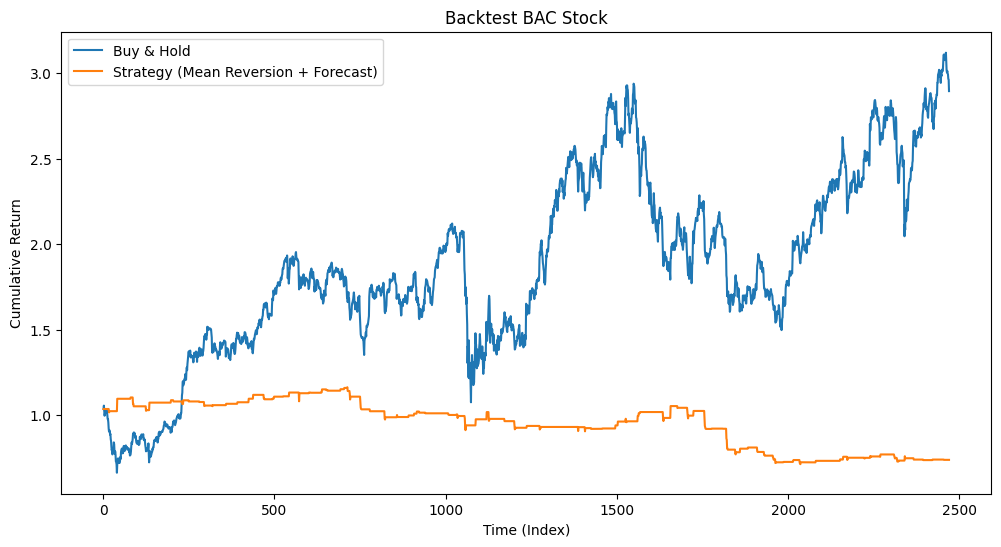

In [89]:
plt.figure(figsize=(12,6))
plt.plot(df['Cumulative_Market'], label='Buy & Hold')
plt.plot(df['Cumulative_Strategy'], label='Strategy (Mean Reversion + Forecast)')
plt.title('Backtest BAC Stock')
plt.xlabel('Time (Index)')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()



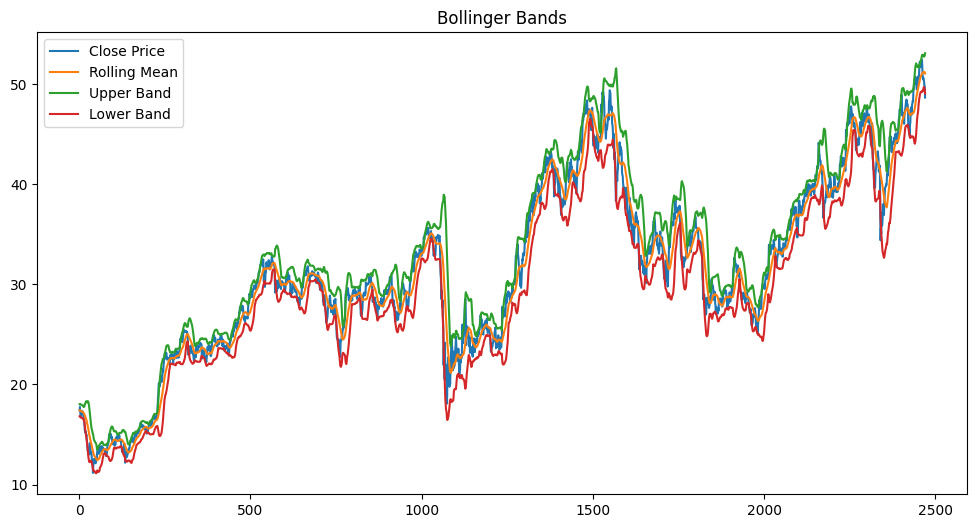

In [92]:
# Vẽ Bollinger Bands
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['Rolling_Mean'], label='Rolling Mean')
plt.plot(df['Upper_Band'], label='Upper Band')
plt.plot(df['Lower_Band'], label='Lower Band')
plt.title('Bollinger Bands')
plt.legend()
plt.show()

##Kiểm tra dữ liệu cuối

In [93]:
print(df[['Close','Lower_Band','Upper_Band','Forecast','Signal','Position','Strategy_Return','Cumulative_Strategy']].tail())

          Close  Lower_Band  Upper_Band  Forecast  Signal  Position  \
2466  50.389999   49.690394   52.745606  0.000337       0       0.0   
2467  50.290001   49.690394   52.745606  0.000642       0       0.0   
2468  49.840000   49.627666   52.779334  0.000364       0       0.0   
2469  49.790001   49.467045   52.843955  0.000760       0       0.0   
2470  48.650002   49.043180   53.074820  0.000262       1       0.0   

      Strategy_Return  Cumulative_Strategy  
2466             -0.0             0.739494  
2467             -0.0             0.739494  
2468             -0.0             0.739494  
2469             -0.0             0.739494  
2470             -0.0             0.739494  
